# 期末報告:透過歷史數據分析隔天的日均溫

組員:林暐盛、吳祐韶、王捷弘

概念:建構RNN的LSTM模型，透過抓取過去數天的日均溫以及前一年同日的日均溫，來預測隔天的溫度

In [39]:
import numpy as np
import csv

In [40]:
import numpy as np
import time
import matplotlib.pyplot as plt


首先輸入資料(資料來源:大氣水文資料庫，https://drive.google.com/open?id=1shsXY7r0TvH4vDfPCeRhIwY5nTJ7wiOY)

In [41]:
data = [line.strip('\n').split(',') for line in open('ml.csv','r') ]

In [42]:
for i in range(30):
    print(data[i])

['Stno', 'Datatime', 'PP01', 'PS01', 'RH01', 'TX01', 'WD01', 'WD02']
['466920', '1897/1/2 AM 12:00:00', '0', '1021.2', '82', '18.6', '1.2', '-9999']
['466920', '1897/1/3 AM 12:00:00', '0', '1020.6', '86', '18.3', '1.4', '-9999']
['466920', '1897/1/4 AM 12:00:00', '0', '1019.4', '86', '19.1', '0.7', '-9999']
['466920', '1897/1/5 AM 12:00:00', '0', '1017.4', '82', '19.5', '0.9', '-9999']
['466920', '1897/1/6 AM 12:00:00', '-9998', '1015', '84', '20.9', '0.9', '-9999']
['466920', '1897/1/7 AM 12:00:00', '0.2', '1015.8', '90', '18.9', '2.6', '-9999']
['466920', '1897/1/8 AM 12:00:00', '0', '1015.3', '84', '19.2', '3', '-9999']
['466920', '1897/1/9 AM 12:00:00', '-9998', '1018.8', '84', '17.4', '3.6', '-9999']
['466920', '1897/1/10 AM 12:00:00', '0.1', '1019.3', '83', '17.5', '5.1', '-9999']
['466920', '1897/1/11 AM 12:00:00', '-9998', '1014.5', '86', '19.3', '2.8', '-9999']
['466920', '1897/1/12 AM 12:00:00', '4.1', '1013.8', '84', '19.4', '3.8', '-9999']
['466920', '1897/1/13 AM 12:00:00'

其中，每一列的第6欄為我們要的溫度(TX01)

In [43]:
d_arr =np.array(data) #將資料轉換成矩陣

In [44]:
d_arr

array([['Stno', 'Datatime', 'PP01', ..., 'TX01', 'WD01', 'WD02'],
       ['466920', '1897/1/2 AM 12:00:00', '0', ..., '18.6', '1.2',
        '-9999'],
       ['466920', '1897/1/3 AM 12:00:00', '0', ..., '18.3', '1.4',
        '-9999'],
       ...,
       ['466920', '2018/3/30 AM 12:00:00', '-9998', ..., '23.7', '4',
        '50'],
       ['466920', '2018/3/31 AM 12:00:00', '0', ..., '24.1', '3.7', '60'],
       ['466920', '2018/4/1 AM 12:00:00', '0', ..., '24.9', '2.8', '50']],
      dtype='<U22')

看看我們要的氣溫資料是否為正確型態

In [45]:
d_arr[1][5]

'18.6'

接著取出t-364(去年的同一天)、t-5到t-1天的溫度作為輸入資料(x)，第t日的資料為輸出(y)

*資料要扣除標題、第一年的元素(因為會造成輸入值找不到去年的對應日)、以及最後六個元素(因為會使日數超出資料範圍)

In [46]:
x = []
y = []
for i in range(365,len(d_arr)-6): #從第二年開始，並從結尾扣除最後一個數據
    element = [float(d_arr[i-364][5]),float(d_arr[i+1][5]),float(d_arr[i+2][5]),float(d_arr[i+3][5]),float(d_arr[i+4][5]),float(d_arr[i+5][5])]
    x.append(element)
    y.append([float(d_arr[i+6][5])])

將x、y轉換為矩陣

In [47]:
X = np.array(x)

In [48]:
Y = np.array(y)

In [49]:
len(X)

42939

In [50]:
X

array([[18.6, 18.1, 18.5, 16.6, 19.5, 14.9],
       [18.3, 18.5, 16.6, 19.5, 14.9, 12.4],
       [19.1, 16.6, 19.5, 14.9, 12.4, 13.2],
       ...,
       [23.9, 22.8, 23. , 21.8, 23.4, 25.1],
       [23.9, 23. , 21.8, 23.4, 25.1, 23.7],
       [17.6, 21.8, 23.4, 25.1, 23.7, 24.1]])

In [51]:
Y

array([[12.4],
       [13.2],
       [13.8],
       ...,
       [23.7],
       [24.1],
       [24.9]])

接著利用sklearn的工具，以9:1的比例隨機分配出訓練與測試資料

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 9487)

再來將x_train與y_train的資料轉換成可以輸入的形式

In [54]:
 y_train

array([[17.5],
       [26.8],
       [26.4],
       ...,
       [19.4],
       [12.9],
       [29.4]])

In [55]:
x_train

array([[14.8, 22.8, 22.5, 22.8, 19.8, 19.7],
       [25.8, 24.4, 24.5, 25. , 26.4, 27.2],
       [29.8, 29.6, 29.8, 30.1, 30.1, 28.4],
       ...,
       [20.4, 22.8, 22.3, 23.5, 24.7, 21.5],
       [17.1, 15.3, 16.3, 14.3, 16.4, 15.7],
       [29.2, 30. , 30.2, 28.8, 29.1, 29.4]])

In [56]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# 開始建構模型

建構RNN模型，以兩層LSTM層以及每層16個神經元作為架構

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Embedding , Flatten
from keras.layers import LSTM,Dropout

In [58]:
model = Sequential()

model.add(LSTM(16, input_shape=(1, 6), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(16, input_shape=(1, 6), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(16,kernel_initializer="random_uniform",activation='relu'))
model.add(Dense(1,kernel_initializer="random_uniform",activation='linear'))

model.compile(loss='mse',optimizer='adam')

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 16)             1472      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


訓練模型

In [60]:
model.fit(x_train,y_train,
         batch_size=64,
         epochs=15)

Epoch 1/15
38645/38645 [==============================] - 5s 127us/step - loss: 193.0396
Epoch 2/15
38645/38645 [==============================] - 2s 56us/step - loss: 19.1007
Epoch 3/15
38645/38645 [==============================] - 2s 55us/step - loss: 14.9588
Epoch 4/15
38645/38645 [==============================] - 2s 51us/step - loss: 13.3373
Epoch 5/15
38645/38645 [==============================] - 2s 51us/step - loss: 11.5844
Epoch 6/15
38645/38645 [==============================] - 2s 51us/step - loss: 10.5108
Epoch 7/15
38645/38645 [==============================] - 2s 51us/step - loss: 9.5244
Epoch 8/15
38645/38645 [==============================] - 2s 51us/step - loss: 8.7581
Epoch 9/15
38645/38645 [==============================] - 2s 52us/step - loss: 7.9394
Epoch 10/15
38645/38645 [==============================] - 2s 50us/step - loss: 7.3423
Epoch 11/15
38645/38645 [==============================] - 2s 51us/step - loss: 6.7771
Epoch 12/15
38645/38645 [===================

訓練完之後，觀察測試資料的狀況

In [61]:
score = model.evaluate(x_test, y_test)

4294/4294 [==============================] - 1s 119us/step


In [62]:
score

3.3117223312313966

In [63]:
predicted = model.predict(x_test)

In [64]:
predicted

array([[23.05918 ],
       [22.76325 ],
       [21.528006],
       ...,
       [16.208258],
       [27.439636],
       [28.570478]], dtype=float32)

嘗試繪製出模式預測的溫度資料以及測試資料的實際溫度來分析

In [65]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

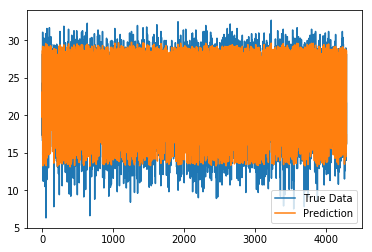

In [66]:
plot_results(predicted,y_test)

資料太多了看不太出來正確性(但是能看出預測資料沒辦法預測極端值的發生)，

我們嘗試擷取前100筆資料

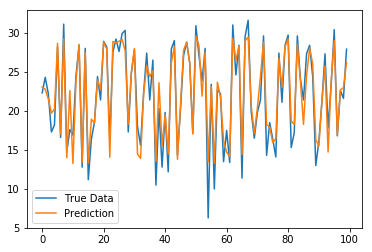

In [67]:
plot_results(predicted[0:100],y_test[0:100])

能夠看出預測資料幾乎都能大致符合實際溫度的走勢，但是當溫度突然大幅上升/下降的時候鬱塞溫度無法到達實際值的變化

最後嘗試單點的預測分析(用1997/1/27、1998/1/22~1998/1/26的氣溫預測1/28的氣溫)

In [68]:
now = np.array([[[17,16.6,14.9,9.6,10,14.7]]])

In [69]:
now

array([[[17. , 16.6, 14.9,  9.6, 10. , 14.7]]])

In [70]:
predicted28 = model.predict(now)
print(predicted28)

[[16.508095]]


預測溫度為16.5，而當天實際均溫為15.6，SE為0.81，且趨勢與實際值相符

# 建立第二個模型，透過增加神經元看是否可以更準確

In [71]:
model2 = Sequential()

model2.add(LSTM(256, input_shape=(1, 6), return_sequences=True))
model2.add(Dropout(0.2))

model2.add(LSTM(128, return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(64,kernel_initializer="random_uniform",activation='relu'))
model2.add(Dense(1,kernel_initializer="random_uniform",activation='linear'))

model2.compile(loss='mse',optimizer='adam')

In [72]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 256)            269312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 474,753
Trainable params: 474,753
Non-trainable params: 0
_________________________________________________________________


In [73]:
model2.fit(x_train,y_train,
         batch_size=64,
         epochs=10)

Epoch 1/10
38645/38645 [==============================] - 18s 474us/step - loss: 49.5873
Epoch 2/10
38645/38645 [==============================] - 16s 425us/step - loss: 5.16070s - los
Epoch 3/10
38645/38645 [==============================] - 17s 430us/step - loss: 4.9041
Epoch 4/10
38645/38645 [==============================] - 18s 473us/step - loss: 4.6442
Epoch 5/10
38645/38645 [==============================] - 16s 419us/step - loss: 4.5896
Epoch 6/10
38645/38645 [==============================] - 16s 404us/step - loss: 4.4920
Epoch 7/10
38645/38645 [==============================] - 16s 415us/step - loss: 4.3901
Epoch 8/10
38645/38645 [==============================] - 17s 450us/step - loss: 4.3166
Epoch 9/10
38645/38645 [==============================] - 18s 469us/step - loss: 4.2934
Epoch 10/10
38645/38645 [==============================] - 16s 427us/step - loss: 4.2700


In [74]:
score = model2.evaluate(x_test, y_test)

4294/4294 [==============================] - 1s 285us/step


In [75]:
score

3.044353869553216

In [76]:
predicted2 = model2.predict(x_test)

In [77]:
def plot_results(predicted2_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted2_data, label='Prediction')
    plt.legend()
    plt.show()

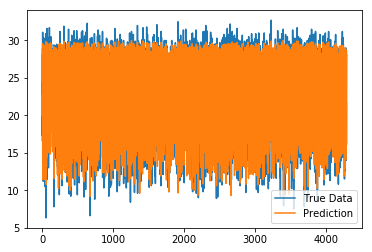

In [78]:
plot_results(predicted2,y_test)

發現其實增加神經元並沒有大幅的改善他在極值時的表現

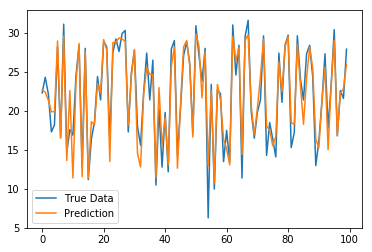

In [79]:
plot_results(predicted2[0:100],y_test[0:100])

In [80]:
x2 = []
y2 = []
for i in range(365,len(d_arr)-372): #扣掉標題，以及前面五個數據，還有最後一個數據
    element = [float(d_arr[i-364][5]),float(d_arr[i+1][5]),float(d_arr[i+2][5]),float(d_arr[i+3][5]),float(d_arr[i+4][5]),float(d_arr[i+5][5]),np.random.normal(0,4)]
    x2.append(element)
    y2.append([float(d_arr[i+6][5])])

In [81]:
X2 = np.array(x2)
Y2 = np.array(y2)
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.1, random_state = 9487)
x2_train = np.reshape(x2_train, (x2_train.shape[0], 1, x2_train.shape[1]))
x2_test = np.reshape(x2_test, (x2_test.shape[0], 1, x2_test.shape[1]))

第三個模型，因為在模擬溫度時發現很難準確的預測到極端事件得發生，因此試試看在資料後面加上隨機的一個亂數，試著打破原本的情況，看可不可以更有效的預測到過熱或過冷的情形

In [82]:
model3 = Sequential()

model3.add(LSTM(16, input_shape=(1, 7), return_sequences=True))
model3.add(Dropout(0.2))

model3.add(LSTM(16, return_sequences=False))
model3.add(Dropout(0.2))

model3.add(Dense(16,kernel_initializer="random_uniform",activation='relu'))
model3.add(Dense(1,kernel_initializer="random_uniform",activation='linear'))

model3.compile(loss='mse',optimizer='adam')

In [83]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 16)             1536      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 3,937
Trainable params: 3,937
Non-trainable params: 0
_________________________________________________________________


In [84]:
model3.fit(x2_train,y2_train,
         batch_size=64,
         epochs=10)

Epoch 1/10
38315/38315 [==============================] - 5s 142us/step - loss: 166.0235
Epoch 2/10
38315/38315 [==============================] - 3s 76us/step - loss: 19.3192
Epoch 3/10
38315/38315 [==============================] - 2s 63us/step - loss: 15.8022
Epoch 4/10
38315/38315 [==============================] - 2s 65us/step - loss: 13.3275
Epoch 5/10
38315/38315 [==============================] - 3s 80us/step - loss: 11.8362
Epoch 6/10
38315/38315 [==============================] - 2s 58us/step - loss: 10.4190
Epoch 7/10
38315/38315 [==============================] - 2s 58us/step - loss: 9.3132
Epoch 8/10
38315/38315 [==============================] - 2s 57us/step - loss: 8.2895
Epoch 9/10
38315/38315 [==============================] - 2s 56us/step - loss: 7.4855
Epoch 10/10
38315/38315 [==============================] - 2s 60us/step - loss: 6.7109


In [85]:
score = model3.evaluate(x2_test, y2_test)

4258/4258 [==============================] - 1s 164us/step


In [86]:
score

3.851256314033407

In [87]:
predicted3 = model3.predict(x2_test)

In [88]:
def plot_results(predicted3_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted3_data, label='Prediction')
    plt.legend()
    plt.show()

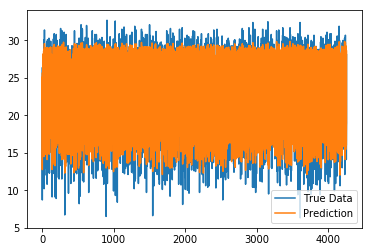

In [89]:
plot_results(predicted3,y2_test)

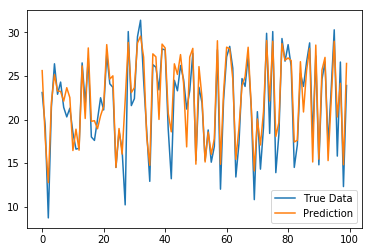

In [90]:
plot_results(predicted3[0:100],y2_test[0:100])

用上述的第一個RNN去產生六月的日均溫（利用五月最後五天的溫度去跑循環）

In [107]:
June1 = np.array([27,32,26,24,30,33])

In [108]:
for i in range(30):
    data=June1[i:i+6]
    data= np.expand_dims(data, axis=0)
    data= np.expand_dims(data, axis=0)
    predictedM1= model.predict(data)
    June1=np.append(June1,predictedM1)

In [109]:
June1[6:36]

array([29.0451622 , 26.3966198 , 25.21570969, 25.89150238, 27.05441284,
       28.02971649, 28.08061218, 27.76098061, 27.61362839, 27.84822083,
       28.17206764, 28.36841393, 28.42143059, 28.42682076, 28.44678688,
       28.4942112 , 28.54348373, 28.57725525, 28.59490776, 28.6053524 ,
       28.61430168, 28.62346649, 28.63165855, 28.63791847, 28.64216805,
       28.64515114, 28.64748383, 28.64945412, 28.65107536, 28.65233803])

溫度看起來有點太穩定，會被自己預測的資料影響走勢，如果要實際使用的話，可能需要加一些權重來平衡前一年當天的溫度以及前五天溫度的影響。

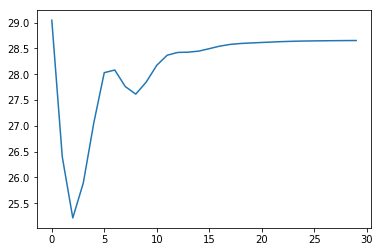

In [110]:
plt.plot(June1[6:36])